In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = '/content/drive/MyDrive/Colab Notebooks/c4_2_4/'
PATH_2 = '/content/drive/MyDrive/Colab Notebooks/c4_2_2/'

In [33]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import re
import shutil
import string

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [40]:
# Общие функции, которые понадобятся для обоих разделов
def get_bag_of_words(Vectorizer, data):
  count_vectorizer = Vectorizer(
      ngram_range=(1, 2),
      analyzer='word',
      binary=False,
      max_df=0.9,
      max_features=1000,
      stop_words='english'
  )

  # Создаем the Bag-of-Words модель
  bag_of_words = count_vectorizer.fit_transform(data)
  return count_vectorizer, bag_of_words



def bag_of_words_as_df(count_vectorizer, bag_of_words):
  # Отобразим Bag-of-Words модель как DataFrame
  feature_names = count_vectorizer.get_feature_names()
  return pd.DataFrame(bag_of_words.toarray(), columns = feature_names)



def get_binary_predict(model, X, threshold):
  pred_proba = model.predict_proba(X)[:, 1]
  return [(1 if i >= threshold else 0) for i in pred_proba]

# Тональность текста
В блокноте text_classification.ipynb разобрали анализ тональности используя полносвязанную сеть. Сделать на тех же данных:
1. tf-idf/count vectorizer + логистическую регрессию
2. Обучить вашу архитектуре сети возможно туже что и была на занятии проверить
    • взять предобученный эмбединг(к примеру word2vec) и загрузить в слой Embedding
    • взять слой Embedding без предобученных весов
Сравнить все подходы в том числе и полносвязанную сеть что лучше отработало

In [4]:
# подготавливаем данные
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

84131840/84125825 [==============================] - 5s 0us/step


In [49]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [29]:
def texts_labels_from_folders(path, folders):
    """Return the text and label arrays from the folders of pos and neg samples"""
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    return texts, np.array(labels).astype(np.int64)

In [34]:
X_train, y_train = texts_labels_from_folders('aclImdb/train', ['neg', 'pos'])

In [47]:
# Посчитаем прогностическую способность логистической регрессии оценивать тональности отзыва
cv_imdb_bow_train, imdb_bow_train = get_bag_of_words(CountVectorizer, X_train)

lr_cv_imdb = LogisticRegression(random_state=44, max_iter=300)
lr_cv_imdb.fit(imdb_bow_train, y_train)
score = f1_score(y_true=y_train, y_pred=lr_cv_imdb.predict(imdb_bow_train))
print("imdb count vectorizer predict score: {}".format(score))


tfidf_imdb_bow_train, imdb_tfidf_bow_train = get_bag_of_words(TfidfVectorizer, X_train)

lr_tfidf_imdb = LogisticRegression(random_state=44, max_iter=300)
lr_tfidf_imdb.fit(imdb_tfidf_bow_train, y_train)
score = f1_score(y_true=y_train, y_pred=lr_tfidf_imdb.predict(imdb_tfidf_bow_train))
print("imdb tfidf predict score: {}".format(score))

imdb count vectorizer predict score: 0.8740945972689492
imdb tfidf predict score: 0.8719488111225215


In [50]:
# Теперь посчитаем с помощью нейронной сети
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6935 - binary_accuracy: 0.5003 - val_loss: 0.6933 - val_binary_accuracy: 0.4924
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6933 - binary_accuracy: 0.5035 - val_loss: 0.6933 - val_binary_accuracy: 0.4924
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6933 - binary_accuracy: 0.5016 - val_loss: 0.6932 - val_binary_accuracy: 0.4924
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6933 - binary_accuracy: 0.4979 - val_loss: 0.6932 - val_binary_accuracy: 0.4924
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6932 - binary_accuracy: 0.4988 - val_loss: 0.6932 - val_binary_accuracy: 0.4924
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6932 - binary_accuracy: 0.5011 - val_loss: 0.6932 - val_binary_accuracy: 0.4924
Epoch 7/10
625/625 [==============================] 

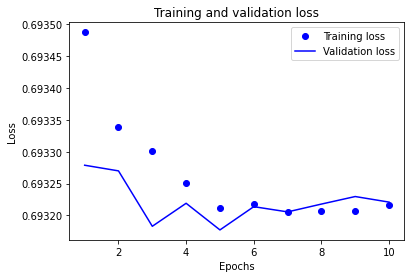

In [54]:
max_features = 10000
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim,),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(145),
  layers.Dense(1)])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

У нейронной сети результаты очень плохие.
Я явно что-то делаю не так с этой сетью, но не могу понять в чем дело. Loss сходится к очень большому значению, а accuracy не возрастает.

Другие варианты сети не вижу смысла даже пробовать делать, пока не пойму в чем дело с этой.

# Классификация текста

In [6]:
combine_df = pd.read_pickle(PATH_2+'combine_df_2.pkl').set_index('id')
combine_df.head()

,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized,tweet_vector
id,,,,,,,,
1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy...","[[0.10685562, 0.28227228, 0.115001515, 0.04018..."
2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thanks, lyft, credit, use, cause, offer, whee...","[[0.13158506, 0.2538712, 0.1569354, 0.08249035..."
3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]","[[0.4116135, 0.14678039, 0.019221649, 0.204781..."
4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in ur,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]","[[-0.015813679, 0.4531453, 0.30910635, -0.0246..."
5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguide, society, motivation]","[[-0.019869618, 0.3732969, 0.10224873, -0.0106..."


## Задание 1
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [8]:
train_N = 31962

train_df = combine_df[:train_N]
test_df = combine_df[train_N:]

tweet_stemmed_train = np.vectorize(lambda x: " ".join(x))(train_df.tweet_stemmed)
tweet_stemmed_test = np.vectorize(lambda x: " ".join(x))(test_df.tweet_stemmed)

y_train = train_df.label

In [9]:
cv_tweet_stemmed_bow_train, tweet_stemmed_bow_train = get_bag_of_words(CountVectorizer, tweet_stemmed_train)
cv_tweet_stemmed_bow_test, tweet_stemmed_bow_test = get_bag_of_words(CountVectorizer, tweet_stemmed_test)

bag_of_words_as_df(cv_tweet_stemmed_bow_train, tweet_stemmed_bow_train).head()

,abl,absolut,accept,account,act,action,actor,actual,ad,adapt,adapt environ,add,adventur,affirm,afternoon,age,ago,agre,ahead,aist,album,allahsoil,allow,alon,alreadi,altwaystoh,altwaystoh healthi,alway,amaz,america,american,angri,angri polar,anim,anniversari,announc,anoth,answer,anxieti,anymor,...,welcom,went,wet,whatev,whatev want,white,wife,win,wine,wish,woh,woman,women,wonder,word,work,work confer,work mindset,workout,world,worri,worst,wow,write,wrong,xxx,yay,ye,yeah,yeah good,year,year old,yesterday,yo,yoga,york,young,youtub,yr,yummi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
lr = LogisticRegression(random_state=44)
lr.fit(tweet_stemmed_bow_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=44, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
pred = get_binary_predict(lr, tweet_stemmed_bow_train, 0.3)
print("stemmed predict score: {}".format(f1_score(y_true=y_train, y_pred=pred)))

stemmed predict score: 0.6093316519546027


In [13]:
# повторим расчёты для tweet_lemmatized
tweet_lemmatized_train = np.vectorize(lambda x: " ".join(x))(train_df.tweet_lemmatized)
tweet_lemmatized_test = np.vectorize(lambda x: " ".join(x))(test_df.tweet_lemmatized)

cv_tweet_lemmatized_bow_train, tweet_lemmatized_bow_train = get_bag_of_words(CountVectorizer, tweet_lemmatized_train)
cv_tweet_lemmatized_bow_test, tweet_lemmatized_bow_test = get_bag_of_words(CountVectorizer, tweet_lemmatized_test)

lr_lemmatized = LogisticRegression(random_state=44)
lr_lemmatized.fit(tweet_lemmatized_bow_train, y_train)
pred = get_binary_predict(lr_lemmatized, tweet_lemmatized_bow_train, 0.3)
print("lemmatized predict score: {}".format(f1_score(y_true=y_train, y_pred=pred)))

lemmatized predict score: 0.5873261205564142


## Задание 2
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

In [14]:
cv_tweet_stemmed_tfidf_train, tweet_stemmed_tfidf_train = get_bag_of_words(TfidfVectorizer, tweet_stemmed_train)
cv_tweet_stemmed_tfidf_test, tweet_stemmed_tfidf_test = get_bag_of_words(TfidfVectorizer, tweet_stemmed_test)

lr_stemmed_tfidf = LogisticRegression(random_state=44)
lr_stemmed_tfidf.fit(tweet_stemmed_tfidf_train, y_train)
pred = get_binary_predict(lr_stemmed_tfidf, tweet_stemmed_tfidf_train, 0.3)
print("stemmed tfidf predict score: {}".format(f1_score(y_true=y_train, y_pred=pred)))

stemmed tfidf predict score: 0.5857328145265889


In [15]:
cv_tweet_lemmatized_tfidf_train, tweet_lemmatized_tfidf_train = get_bag_of_words(TfidfVectorizer, tweet_lemmatized_train)
cv_tweet_lemmatized_tfidf_test, tweet_lemmatized_tfidf_test = get_bag_of_words(TfidfVectorizer, tweet_lemmatized_test)

lr_lemmatized_tfidf = LogisticRegression(random_state=44)
lr_lemmatized_tfidf.fit(tweet_lemmatized_tfidf_train, y_train)
pred = get_binary_predict(lr_lemmatized_tfidf, tweet_lemmatized_tfidf_train, 0.3)
print("lemmatized tfidf predict score: {}".format(f1_score(y_true=y_train, y_pred=pred)))

lemmatized tfidf predict score: 0.5751633986928105


## Задание 3
Выведите результаты f1-score всех моделей, сделайте вывод.

In [16]:
print("stemmed bag-of-words predict score: {}".format(f1_score(y_true=y_train, y_pred=get_binary_predict(lr, tweet_stemmed_bow_train, 0.3))))
print("lemmatized bag-of-words predict score: {}".format(f1_score(y_true=y_train, y_pred=get_binary_predict(lr_lemmatized, tweet_lemmatized_bow_train, 0.3))))
print("stemmed tfidf predict score: {}".format(f1_score(y_true=y_train, y_pred=get_binary_predict(lr_stemmed_tfidf, tweet_stemmed_tfidf_train, 0.3))))
print("lemmatized tfidf predict score: {}".format(f1_score(y_true=y_train, y_pred=get_binary_predict(lr_lemmatized_tfidf, tweet_lemmatized_tfidf_train, 0.3))))

stemmed bag-of-words predict score: 0.6093316519546027
lemmatized bag-of-words predict score: 0.5873261205564142
stemmed tfidf predict score: 0.5857328145265889
lemmatized tfidf predict score: 0.5751633986928105


Похоже, что модели bag-of-words лучше работают с логистической регрессией на наших данных. Также кажется, что stemmed-данные показывают более хорошие прогностические способности для логистической регрессии по сравнению с лемматизированными.

## Задание 4
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

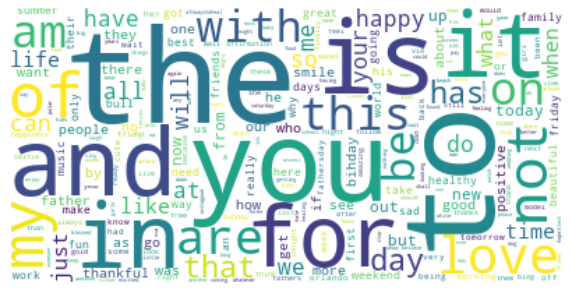

In [17]:
words = []
for tweet_words in combine_df.tweet_token: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

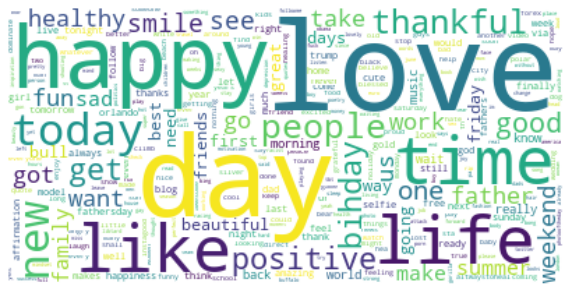

In [18]:
# и повторим по фильтрованным токенам
words = []
for tweet_words in combine_df.tweet_token_filtered: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Задание 5
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

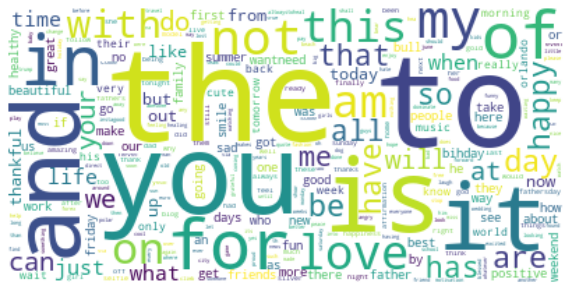

In [19]:
words = []
for tweet_words in combine_df.tweet_token[combine_df.label == 0]: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

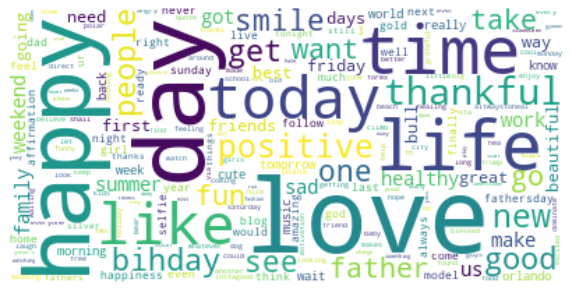

In [20]:
# то же самое для фильтрованных токенов
words = []
for tweet_words in combine_df.tweet_token_filtered[combine_df.label == 0]: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Задание 6
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 

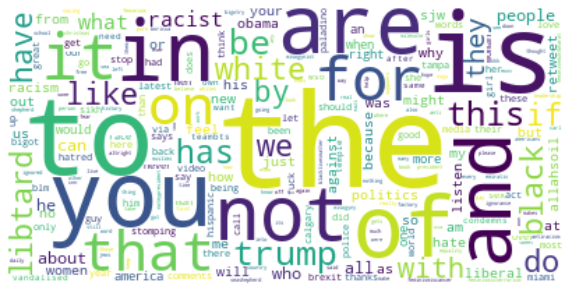

In [21]:
words = []
for tweet_words in combine_df.tweet_token[combine_df.label == 1]: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

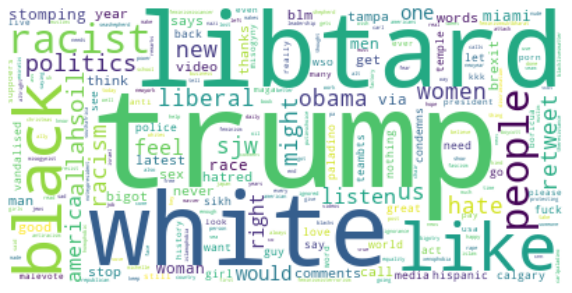

In [22]:
# и для фильтрованных...
words = []
for tweet_words in combine_df.tweet_token_filtered[combine_df.label == 1]: 
    words.extend(tweet_words)

wordfreq = collections.Counter(words)

wordcloud = WordCloud(
 background_color='white',
 max_words=2000,
 stopwords=stopwords
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(10,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()